<a href="https://colab.research.google.com/github/gitnicolas343/PARCIAL2/blob/main/PArcial_2_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](http://vis-www.cs.umass.edu/lfw/)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


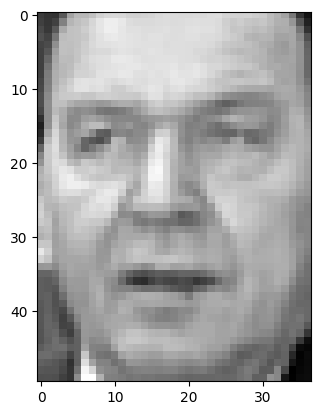

In [ ]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [ ]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1 en términos de validación cruzada con gridserachCV y en el conjunto de test (30% de los datos originales), fijando el score del gridsearch en términos del acc y el f1. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 1.


# ***punto 2***

**EVALUCION DE MODELOS**

realiza un búsqueda de hiperparámetros usando GridSearchCV para ajustar y entrenar diferentes clasificadores en un conjunto de datos.

1. se importan las librerias necesarias con los modelos y sus componentes

2. Cada modelo tiene su propio pipeline, que es una secuencia de pasos para el procesamiento de los datos y la aplicación del modelo. En este caso, se aplica un MinMaxScaler para escalar los datos antes de entrenar el clasificador.
Para cada modelo, se define un diccionario con los hiperparámetros a optimizar.
3. Se define una lista de nombres de modelos (label_models).
4. El código recorre cada modelo en la lista steps y parameters, creando un GridSearchCV para optimizar los hiperparámetros de cada clasificador.
5. el GridSearchCV reliza una busqueda de los mejores parámetros utilizando validación cruzada de 5 folks .para que  scoring se evalue  con metricas accuracy y f1, luego el modelo se rentrena utilizan los mejores parametros de accuracy en refit
refit='accuracy': Después de la búsqueda, el modelo se vuelve a entrenar utilizando los mejores parámetros basados en la métrica de precisión.
Los modelos son entrenados sobre los datos de entrenamiento (Xtrain, ytrain).

6. Después de entrenar y optimizar cada modelo, los resultados  se guardan en una lista llamada models.Luego, joblib.dump() guarda esta lista de modelos entrenados en un archivo .pkl llamado 'results/lfw_models.pkl'

7. se muestran los resultados.



In [77]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib

#listas de pasos (pipelines)
steps = [

    [('nor', MinMaxScaler()), ('cla', LogisticRegression())],  # Pipeline1
    [('nor', MinMaxScaler()), ('cla', SGDClassifier())],  # Pipeline2
    [('nor', MinMaxScaler()), ('cla', SVC())],  # Pipeline3
    [('nor', MinMaxScaler()), ('cla', GaussianNB())],  # Pipeline4
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],  # Pipeline5
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],  # Pipeline6
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier())],  # Pipeline7
    [('nor', MinMaxScaler()), ('cla', GaussianProcessClassifier())],  # Pipeline8

]

#hiperparámetros a buscar para cada pipeline
parameters = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3],'cla__solver': ['saga', 'lbfgs'], 'cla__multi_class': ['multinomial']},# LogisticRegression
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]},
    {'cla__C': [1, 10, 1e2, 1e3, 1e4], 'cla__gamma': [1e-3, 1e-2, 1e-1, 1, 10]},  # SVC
    {'cla__var_smoothing': np.arange(50, 54, 0.01)  },  # GaussianNB
    {'cla__solver': ['lsqr', 'eigen'], 'cla__shrinkage': [None, 'auto', 0.1, 0.5, 1]},  # LDA
    {'cla__n_neighbors': [3, 5, 7, 10], 'cla__metric': ['euclidean', 'manhattan'], 'cla__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},  # KNeighborsClassifier (Pipeline6)
    {'cla__n_estimators': [10,20,30,40,50, 100, 200,300], 'cla__max_depth': [None, 10,20,30,40,50, 100, 200,300]},  # RandomForestClassifier
    {'cla__kernel': [RBF(), Matern(), DotProduct()]}
]

# Nombres de los modelos
label_models = [
    'MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVC', 'MinMax_GaussianNB','MinMax_LDA',
    'MinMax_KNN', 'MinMax_RF', 'MinMax_GPC'
]

models = []
filename = 'results/lfw_models'

#iteracion para recorrer los modelos y realizar GridSearchCV
for i in range(len(steps)):  # Recorrer los modelos según la lista pipeline
    print(f'Modelo {i+1}/{len(steps)}: {label_models[i]}')

    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1, cv=5,
                               scoring=['accuracy', 'f1'], refit='accuracy', verbose=10)  # GridSearch para el modelo i
    grid_search.fit(Xtrain, ytrain)  # Entrenar el modelo

    # Guardar el modelo entrenado
    models.append(grid_search)

    # Guardar el modelo utilizando joblib
    joblib.dump(models, filename + ".pkl")

# Imprimir los resultados de los mejores modelos
for i, model in enumerate(models):
    print(f'Modelo: {label_models[i]}')
    print(f'Mejor Parámetro: {model.best_params_}')
    print(f'Mejores Resultados de GridSearch: {model.best_score_}')


Modelo 1/8: MinMax_Logistic
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Modelo 2/8: MinMax_SGD
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Modelo 3/8: MinMax_SVC
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Modelo 4/8: MinMax_GaussianNB
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Modelo 5/8: MinMax_LDA
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Modelo 6/8: MinMax_KNN
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Modelo 7/8: MinMax_RF
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Modelo 8/8: MinMax_GPC
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Modelo: MinMax_Logistic
Mejor Parámetro: {'cla__C': 10, 'cla__multi_class': 'multinomial', 'cla__solver': 'saga'}
Mejores Resultados de GridSearch: 0.8157397176181705
Modelo: MinMax_SGD
Mejor Parámetro: {'cla__alpha': 0.01}
Mejores Resultados de GridSearch: 0.7547145488029466
Modelo: MinMax_SVC
Mejor Parámetro:

# **METRICAS**



# **COMPARACION DE SCORE**

este apartado se encarga de extraer y visualizar los mejores resultados de la búsqueda de hiperparámetros realizada con GridSearchCV.

1.  Se crea una lista best_scores que contiene los mejores puntajes de precisión de cada modelo entrenado, extraídos de los resultados de GridSearchCV en el codigo anterior.

2. Se utiliza Matplotlib para crear un gráfico de barras horizontal. en el grafico se pltean las etiquetas de los modelos guardades en label_models, y los valores de los mejores scores en el eje horizontal.

3. se añaden etiquetas titulos, tamaño de figura etc.

4. se muestra el barh_plot

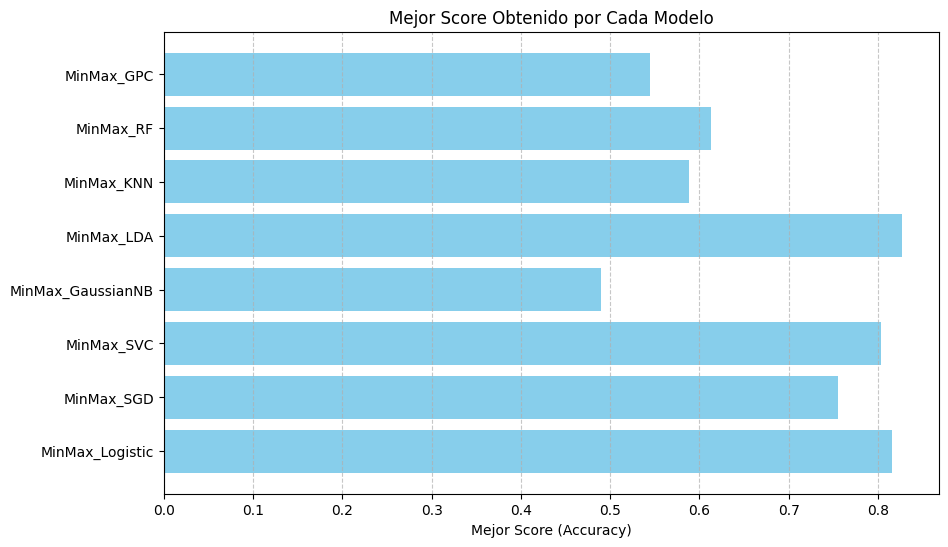

In [78]:
best_scores = [model.best_score_ for model in models]

#  gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(label_models, best_scores, color='skyblue')
plt.xlabel('Mejor Score (Accuracy)')
plt.title('Mejor Score Obtenido por Cada Modelo')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# **MATRIZ DE CONFUCION PARA RENDIMIENTO DEL MODELO**

luego se realiza la evaluación de los modelos previamente entrenados sobre el conjunto de datos de prueba, mostrando resultados, la matriz de confusión y el reporte de clasificación.

1. El modelo guardado previamente se carga para la evaluacion  sobre el conjunto de prueba. estos estan en el archivo filename + ".pkl".
2. Se itera sobre la lista de modelos guardados en my_model_loaded.
3. ara cada modelo, se obtiene el mejor estimador utilizando best_stimator_ , y se usa para predecir las etiquetas del conjunto de pruebas.
4. Se genera una matriz de confusión con la función plot_confusion_matrix().
5. se usa plt.autoscale() para ajustar automáticamente el gráfico para una visualizacion correcta.
6. se usa classifier_report_  para presentar el repoprte de las metricas (decidi dejar la originales del notebook)


Evaluando modelo MinMax_Logistic (1/8)


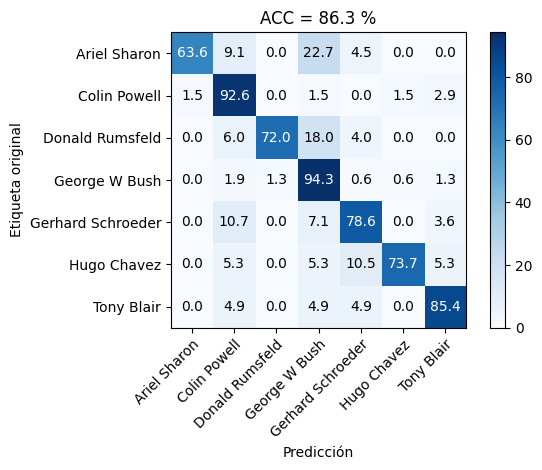

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.82      0.93      0.87        68
  Donald Rumsfeld       0.95      0.72      0.82        50
    George W Bush       0.88      0.94      0.91       159
Gerhard Schroeder       0.73      0.79      0.76        28
      Hugo Chavez       0.88      0.74      0.80        19
       Tony Blair       0.85      0.85      0.85        41

         accuracy                           0.86       387
        macro avg       0.86      0.80      0.82       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_SGD (2/8)


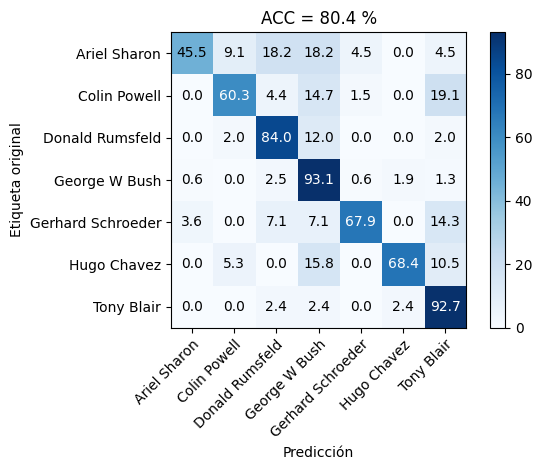

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.45      0.59        22
     Colin Powell       0.91      0.60      0.73        68
  Donald Rumsfeld       0.75      0.84      0.79        50
    George W Bush       0.85      0.93      0.89       159
Gerhard Schroeder       0.86      0.68      0.76        28
      Hugo Chavez       0.76      0.68      0.72        19
       Tony Blair       0.62      0.93      0.75        41

         accuracy                           0.80       387
        macro avg       0.80      0.73      0.75       387
     weighted avg       0.82      0.80      0.80       387

Evaluando modelo MinMax_SVC (3/8)


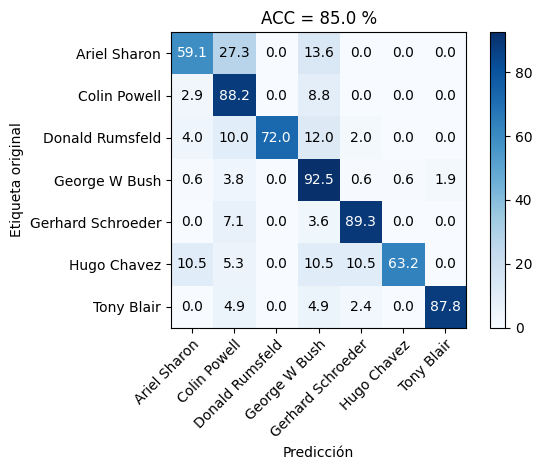

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387

Evaluando modelo MinMax_GaussianNB (4/8)


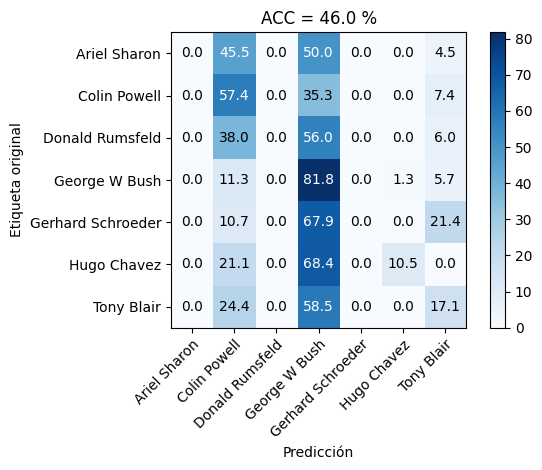

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.38      0.57      0.46        68
  Donald Rumsfeld       0.00      0.00      0.00        50
    George W Bush       0.52      0.82      0.64       159
Gerhard Schroeder       0.00      0.00      0.00        28
      Hugo Chavez       0.50      0.11      0.17        19
       Tony Blair       0.23      0.17      0.19        41

         accuracy                           0.46       387
        macro avg       0.23      0.24      0.21       387
     weighted avg       0.33      0.46      0.37       387

Evaluando modelo MinMax_LDA (5/8)


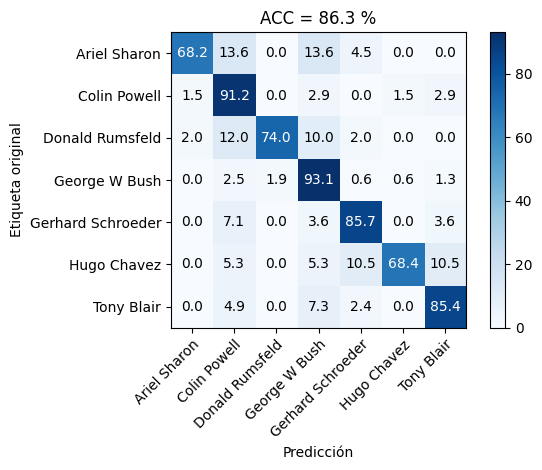

                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.68      0.77        22
     Colin Powell       0.78      0.91      0.84        68
  Donald Rumsfeld       0.93      0.74      0.82        50
    George W Bush       0.91      0.93      0.92       159
Gerhard Schroeder       0.80      0.86      0.83        28
      Hugo Chavez       0.87      0.68      0.76        19
       Tony Blair       0.83      0.85      0.84        41

         accuracy                           0.86       387
        macro avg       0.86      0.81      0.83       387
     weighted avg       0.87      0.86      0.86       387

Evaluando modelo MinMax_KNN (6/8)


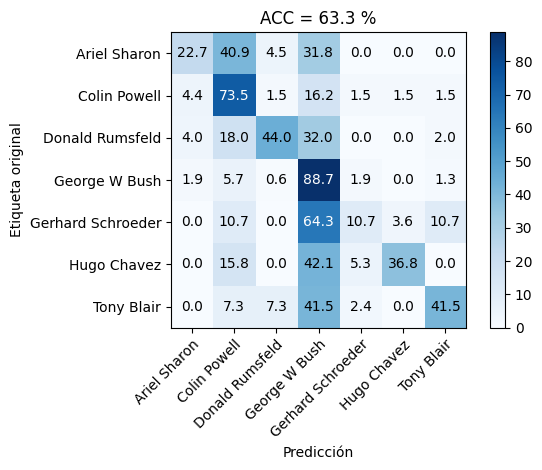

                   precision    recall  f1-score   support

     Ariel Sharon       0.38      0.23      0.29        22
     Colin Powell       0.58      0.74      0.65        68
  Donald Rumsfeld       0.79      0.44      0.56        50
    George W Bush       0.65      0.89      0.75       159
Gerhard Schroeder       0.33      0.11      0.16        28
      Hugo Chavez       0.78      0.37      0.50        19
       Tony Blair       0.71      0.41      0.52        41

         accuracy                           0.63       387
        macro avg       0.60      0.45      0.49       387
     weighted avg       0.63      0.63      0.60       387

Evaluando modelo MinMax_RF (7/8)


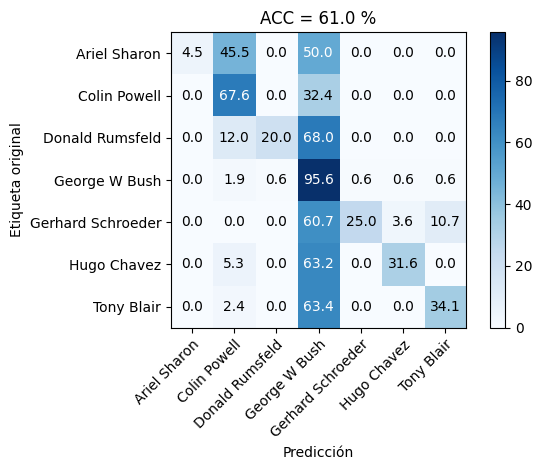

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.05      0.09        22
     Colin Powell       0.69      0.68      0.68        68
  Donald Rumsfeld       0.91      0.20      0.33        50
    George W Bush       0.55      0.96      0.70       159
Gerhard Schroeder       0.88      0.25      0.39        28
      Hugo Chavez       0.75      0.32      0.44        19
       Tony Blair       0.78      0.34      0.47        41

         accuracy                           0.61       387
        macro avg       0.79      0.40      0.44       387
     weighted avg       0.71      0.61      0.56       387

Evaluando modelo MinMax_GPC (8/8)


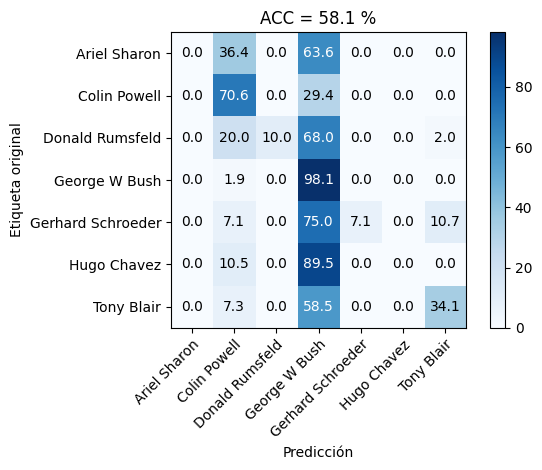

                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        22
     Colin Powell       0.63      0.71      0.67        68
  Donald Rumsfeld       1.00      0.10      0.18        50
    George W Bush       0.55      0.98      0.70       159
Gerhard Schroeder       1.00      0.07      0.13        28
      Hugo Chavez       0.00      0.00      0.00        19
       Tony Blair       0.78      0.34      0.47        41

         accuracy                           0.58       387
        macro avg       0.56      0.31      0.31       387
     weighted avg       0.62      0.58      0.49       387



In [79]:
#%% evaluar sobre Xtest

# Carga de modelo previamente guardado utilizando joblib
my_model_loaded = joblib.load(filename+".pkl")

# Iteracion sobre la lista de modelos cargados
for i in range(len(my_model_loaded)):
    # Imprimir el nombre y el índice del modelo que se está evaluando
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    # predicciones sobre los datos de prueba (Xtest) utilizando el mejor estimador de cada modelo
    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)
    # matriz de confusión
    # Mostramos el porcentaje de exactitud en el título del gráfico
    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                         )
    #auto ajuste
    plt.autoscale()

    plt.show()
    #reporte de clasificaion
    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )

    print(cr)



# **curva ROC**

el siguiente codigo se uso para graficar y calcular la curva roc de cada modelo:

1. convierte las etiquetas de entrenamiento y prueba mediante label_binarize()
2. se plantea la funcion roc_multiclass() toma las etiquetas binarizadas en el paso anterior  y las probabilidades de predicción del modelo. Para calcular cada clse :
* FPR:falsos positivos.
* TPR: verdaderos positivos.
* AUC: area bajo la curva ROC
3. se grafica la curva roc  con roc_auc_mc()
-> El gráfico final muestra la tasa de verdaderos positivos frente a la tasa de falsos positivos.

4. El código recorre todos los modelos entrenados previamente.

**(el siguiente paso es una ayuda de chatgpt para el error de visualizacion de modelos de que tiene metodo desicion_function)**

5. Para cada modelo, si el modelo tiene el método decision_function (como los SVM), se usa este método para obtener las puntuaciones de decisión. Si no, se usa predict_proba (común en clasificadores como Random Forest, Logistic Regression) para obtener las probabilidades de cada clase.
Luego, se calculan las curvas ROC y se grafican con la función roc_auc_mc(), etiquetando cada gráfico con el nombre del modelo correspondiente.

Evaluando modelo MinMax_Logistic (1/8)


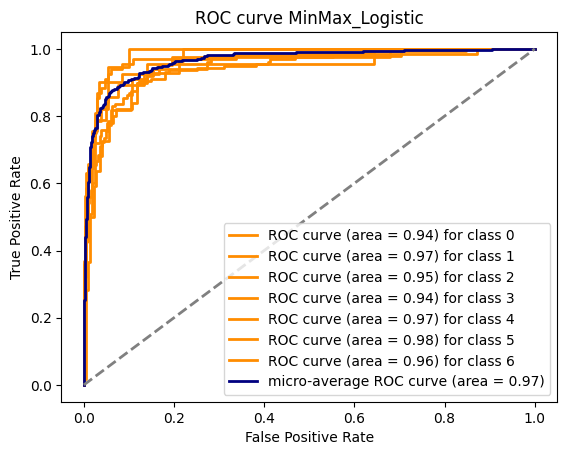

Evaluando modelo MinMax_SGD (2/8)


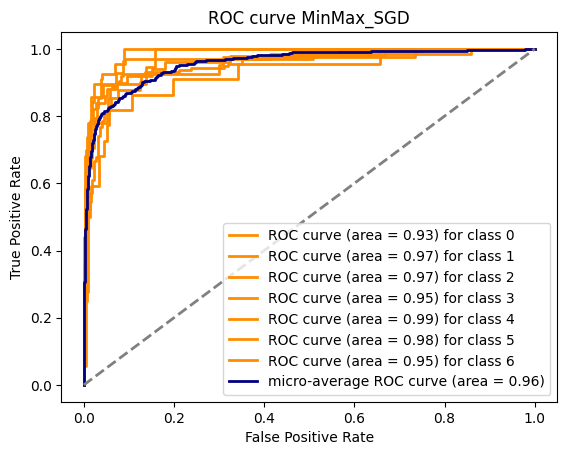

Evaluando modelo MinMax_SVC (3/8)


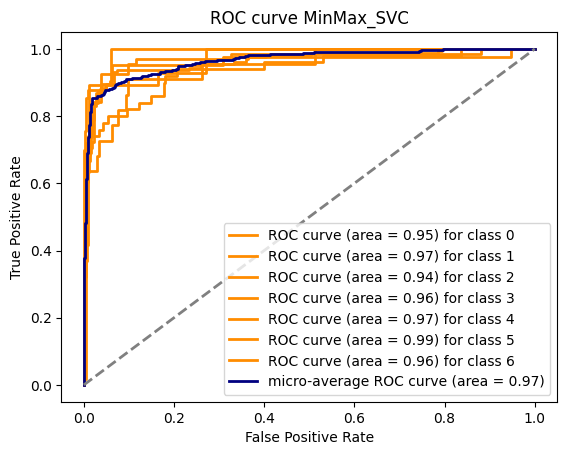

Evaluando modelo MinMax_GaussianNB (4/8)


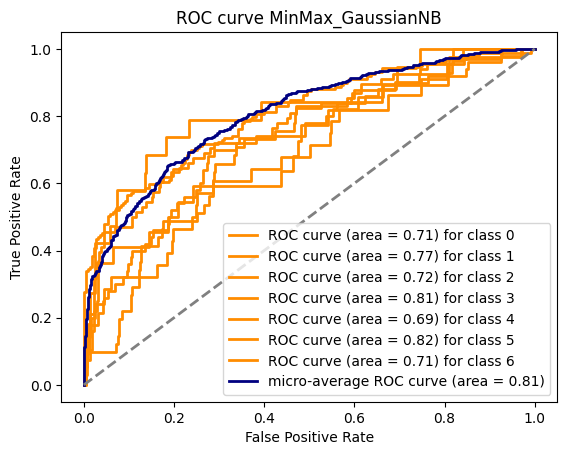

Evaluando modelo MinMax_LDA (5/8)


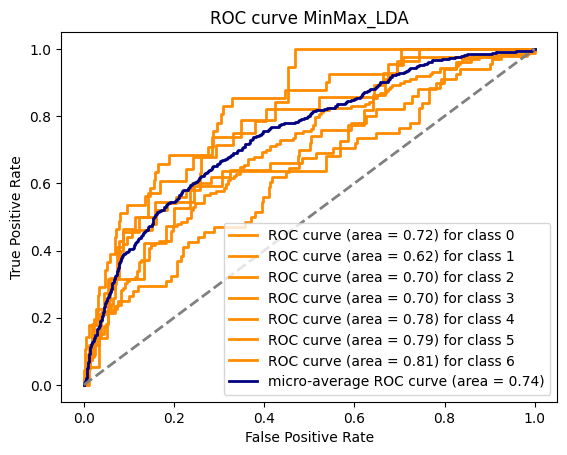

Evaluando modelo MinMax_KNN (6/8)


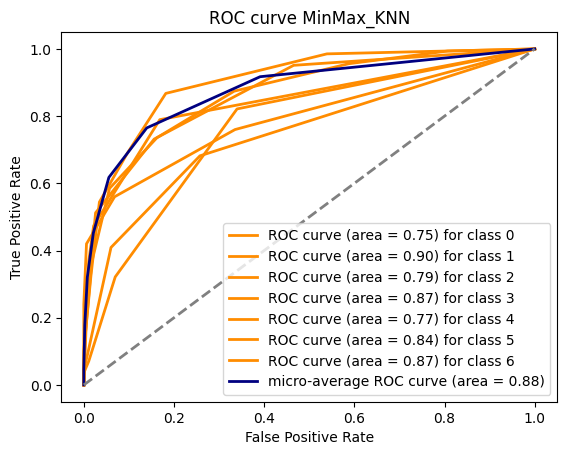

Evaluando modelo MinMax_RF (7/8)


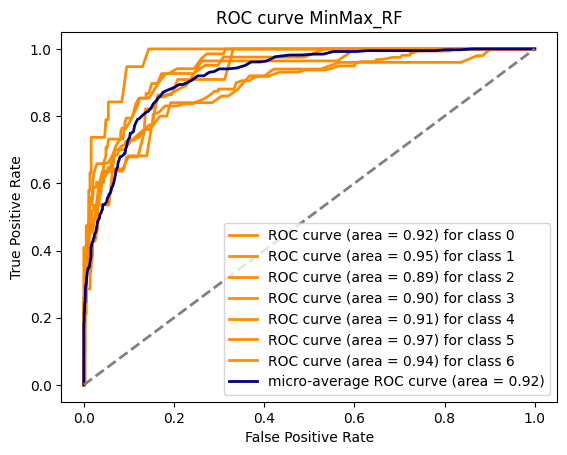

Evaluando modelo MinMax_GPC (8/8)


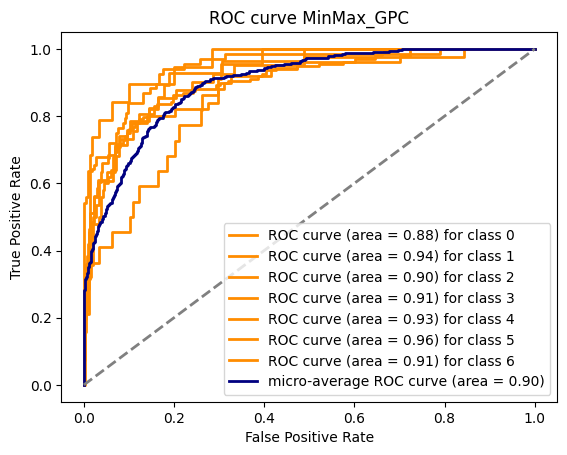

In [80]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#  etiquetas multicategoria
ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

# calculos para  la curva ROC para clasificación multicategoría
def roc_multiclass(y_true, y_score):
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcula la media ponderada de las AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    return roc_auc, fpr, tpr, n_classes

# Función para graficar la curva ROC
def roc_auc_mc(roc_auc, fpr, tpr, n_classes, title):
    plt.figure()
    lw = 2

    # curva ROC para cada clase
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw,
                 label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))

    # curva ROC micro promedio
    plt.plot(fpr["micro"], tpr["micro"], color='navy', lw=lw,
             label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# evalicacion la curva ROC para cada modelo
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i], i+1, len(my_model_loaded)))

    # odtencio de  las probabilidades o las decisiones del modelo dependiendo de si se soporta `decision_function` o no
    if hasattr(my_model_loaded[i], 'decision_function'):
        ytest_score = my_model_loaded[i].decision_function(Xtest)
    else:
        ytest_score = my_model_loaded[i].predict_proba(Xtest)  # se usa  `predict_proba`o  si no hay `decision_function`

    #curva roc (calculos)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b, ytest_score)

    # grafica
    roc_auc_mc(roc_auc, fpr, tpr, n_classes, 'ROC curve ' + label_models[i])


# **JUSTIFICACION DE HIPERPARAMETROS**




1.   **REGRESION LOGISTICA:**
* **cla__C: [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]**:Este hiperparámetro controla la regularización en la regresión logística.
esta regularizacion  verifica y explora el modelo, en como afecta con distitos valores ayuda a evitar el sobreajuste.
* **cla__solver: ['saga', 'lbfgs']:** determina el tipo de algoritmo para resolver el problema de optimizacion
-lbfg:Es eficiente y funciona bien con datos pequeños o medianos.
-saga: una version de sgd con regularizacion de l1

Al probar ambos, se permite al modelo seleccionar el algoritmo más adecuado para el problema.

* **cla__multi_class: ['multinomial'] :** Este parámetro determina cómo se maneja un problema de clasificación multiclase. En la regresión logística,

- multinomial: Se ajusta un modelo multinomial de regresión logística que optimiza directamente las probabilidades de clase.

Esta elección se debe a que la clasificación multinomial tiene una representación más directa de las probabilidades para cada clase, lo que puede mejorar el rendimiento del modelo

2. ** SGD:**
* **cla__alpha: [1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3]**: El parámetro alpha controla la penalizacion del ecitando el sobreajuste con valores grandes (el modelo se hace mas simple), con valores pequeños  el modelo puede ajustarse demaciado a los datos  el modelo se hace más simple (no aprenda suficiente)

Se usan valores de alpha en un rango amplio (de 1e-3 a 1e3) para tantear  distintas opciones y encontrar valores adecuados.

3. **SVC**
* **cla__C: [1, 10, 1e2, 1e3, 1e4]:**  controla la penalización de los errores en el modelo. Es un valor que ajusta el margen de decisión del clasificador, como los anterores se eleige una gama para explorar y tantear la respuesta del modelo.

* **cla__gamma: [1e-3, 1e-2, 1e-1, 1, 10]**: controla la influencia de cada punto de entrenamiento en la decisión del modelo, es similar al parametro alfe de los demas modelos, al igual que los demas se explora una gama de valores para odservar la respuesta del modelo

4. **GaussianNB (Naive Bayes Gaussiano)**: solo tiene un hiperparametro,smoothing, controla la cantidad de suavizado que se aplica a la varianza de las distribuciones gaussianas utilizadas en el modelo. aqui se aplico un barrido por tanteo dentro del mejor valor que ajusta al hiperparametro.

5. **LDA**
* **cla__solver: ['lsqr', 'eigen']:** determina el algoritmo que se usará para calcular los coeficientes del modelo LDA:
 - lsqr (Least Squares): Este método es más robusto y se usa generalmente cuando hay más características que muestras.
 - eigen: Este método utiliza descomposición en valores propios (autovalores), y es el método estándar utilizado en LDA cuando las muestras son más grandes que las características.  
* **cla__shrinkage: [None, 'auto', 0.1, 0.5, 1]**: ayuda a evitar el sobre ajuste controlando la  regularización de los coeficientes, en este caso se pusiron en None para no hacerlo, auto para que seleccionen por el mode y una lista para tantear.

6. **KNeighborsClassifier** :
* **cla__n_neighbors: [3, 5, 7, 10]**: Este parámetro define el número de vecinos más cercanos que se considerarán al clasificar un punto de datos, en consecuencia se cubre una gama de valores para determinar por tanteo cuantos vecinos son los indicados en las predicciones
* **cla__metric: ['euclidean', 'manhattan']**: define la metrica de la medida de las dicstancias a calcular:

* euclidean : doistancia euclidina 'linea recta'
* manhattan : usa las lineas de las cuadriculas

se usan ambos metodo para determinar cual sera el adecuado, euclidean es el clasico usado, sin embargo mahantan permite identificar si no hay relacion lineal entre las distancias de los vecinos.

* **cla__algorithm: ['auto', 'ball_tree', 'kd_tree', 'brute']**:

se determina el algoritmo para encontrar los vecinos mas cercanos

- auto: El modelo selecciona automáticamente el mejor algoritmo en función del tamaño y las características del conjunto de datos.
- ball_tree: Es un algoritmo eficiente cuando los datos tienen muchas dimensiones. Usa una estructura de árbol para dividir el espacio de características.
- kd_tree: Es otro algoritmo eficiente para datos multidimensionales que utiliza un árbol de k-d para organizar los puntos en el espacio.
- brute: El algoritmo de búsqueda por fuerza bruta, que compara cada punto con todos los demás. Es más lento pero útil para conjuntos de datos más pequeños.

7. **RF**:

* **cla__n_estimators: [10, 20, 30, 40, 50, 100, 200, 300]:** controla el numero de arboles dentro del bosque, entre mas hallan se evita mas la varianza, sin embargo se usan valores distintos para explorar el efecto.

* **cla__max_depth: [None, 10, 20, 30, 40, 50, 100, 200, 300]:** arboles mas profundos captan complejidades del modelo pero con riesgo de sobreajuste, sin embargo los mas pequeños avitan el sobre ajuste , selecciona una gama de de arboles en esta tarea.


8. **GPC :**

* **cla__kernel: [RBF(), Matern(), DotProduct()]:**
*RBF: Mide la similitud entre dos puntos en función de su distancia euclidiana. util para relaciones no lineales entre los datos

* matern : El kernel Matern es una familia de kernels que generaliza el kernel RBF, El kernel Matern puede ser más flexible que el RBF, ya que puede justarse mejor a ciertos tipos de datos con patrones más irregulares, es util para captar patrones irregulares que RBF no captura

* DotProduct: mide la similitud entre dos puntos como el producto interno de sus características., berificar las relaciones entre los datos dependientes del producto punto.









NOTA:

la IA se utiliza para escribir y ajustar codigos asi como explicar los mismos y ampliar informacion y ejemplos practicos de los modelos y sus hiperparametros.